# Libraries

In [2]:
#!pip install lightgbm

  Using cached https://files.pythonhosted.org/packages/80/28/fecd02e7856e36afcdc71ee968b1b3859b3bc784e042991d5520e4d7be2c/lightgbm-3.1.1-py2.py3-none-win_amd64.whl


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression 
from sklearn.svm import SVR
from sklearn import metrics
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from scipy.stats import uniform, randint as sp_randint
#from matplotlib import style

# Read Data

In [4]:
total_case_df = pd.read_excel("Case_Data.xlsx","Total Cases")
air_df = pd.read_csv("AQI_Data_31Jan2021.csv")
air_df.Date = pd.to_datetime(air_df.Date,dayfirst=True)

# Data Mining

In [8]:
#air_df_copy=air_df.copy(deep=True)
#air_df=air_df_copy.copy(deep=True)
air_df.Date=air_df.Date+pd.to_timedelta(5,unit="d")

In [9]:
air_df.sort_values(by="Date",inplace=True)

In [10]:
air_df["City"].value_counts()

Delhi         6992
Mumbai        3864
Chennai       1472
Kolkata       1288
Pune          1288
Hyderabad     1104
Lucknow        736
Ahmedabad      184
Chandigarh     184
Name: City, dtype: int64

In [11]:
def data_mining (cases_city,aqi_city):
    case_df = total_case_df[total_case_df['District']==cases_city].transpose()
    case_df.drop(index=['State','District'],inplace=True)
    if len(case_df.columns)==1:
        case_df.columns=["Total Cases"]
    elif len(case_df.columns)==2:
        case_df.columns=["Total Cases","1"]
        case_df.drop(columns="1",inplace=True)
    case_df['Date'] = case_df.index
    first_index_value=case_df.first_valid_index()
    if case_df.loc[first_index_value,"Total Cases"]==np.nan:
        prev_value=0
    else:
        prev_value=case_df.loc[first_index_value,"Total Cases"]
        prev_date=case_df.loc[first_index_value,"Date"]
        daily_cases=0
    for i,row in case_df.iterrows():
        if(str(row["Total Cases"])!="nan"):
            if prev_date!=row["Date"]:
                daily_cases=row["Total Cases"]-prev_value
                case_df.at[i,"Total_Day_Cases"]=daily_cases
                prev_value=row["Total Cases"]
                prev_date=row["Date"]
            else:
                case_df.at[i,"Total_Day_Cases"]=daily_cases
    case_df.reset_index(drop=True, inplace=True)
    case_df = (air_df[air_df.City == aqi_city]).join(case_df.set_index('Date'),on='Date')
    return(case_df)

In [12]:
li=[]
aqi_city=['Delhi','Mumbai','Chennai','Kolkata','Hyderabad']
for i,city in enumerate(['Delhi','Mumbai City','Chennai','Kolkata','Hyderabad']):
    city_df=data_mining(city,aqi_city[i])
    li.append(city_df)
major_cities_df=pd.concat(li,ignore_index=False,axis=0)

In [13]:
major_cities_df["Total_Day_Cases"].sort_values()

12108   -819.0
3276    -819.0
12292   -819.0
11372   -819.0
10452   -819.0
         ...  
184        NaN
3864       NaN
1288       NaN
14904      NaN
10120      NaN
Name: Total_Day_Cases, Length: 14720, dtype: float64

In [14]:
major_cities_df.drop(columns = ['Unnamed: 0','State','Station_Name','NH3_average','NH3_minimum','NH3_maximum'],inplace=True)
pollutant_cols=list(major_cities_df.drop(columns=["City","Station_ID","Date","Total Cases","Total_Day_Cases"]).columns)
major_cities_df.dropna(subset=pollutant_cols,how="all",axis=0,inplace=True)
major_cities_df.dropna(subset=["Total Cases"],how="all",axis=0,inplace=True)
major_cities_df

,City,Station_ID,Date,PM2.5_average,PM2.5_minimum,PM2.5_maximum,PM10_average,PM10_minimum,PM10_maximum,NO2_average,...,SO2_minimum,SO2_maximum,CO_average,CO_minimum,CO_maximum,OZONE_average,OZONE_minimum,OZONE_maximum,Total Cases,Total_Day_Cases
17111,Delhi,site_106,2020-07-11,58.0,19.0,84.0,89.0,48.0,122.0,24.0,...,NaN,NaN,31.0,23.0,39.0,82.0,27.0,151.0,110921,1781.0
11591,Delhi,site_1560,2020-07-11,94.0,42.0,157.0,130.0,82.0,177.0,27.0,...,13.0,17.0,25.0,20.0,40.0,46.0,6.0,80.0,110921,1781.0
1287,Delhi,site_107,2020-07-11,66.0,15.0,135.0,92.0,53.0,131.0,7.0,...,NaN,NaN,99.0,94.0,101.0,44.0,17.0,62.0,110921,1781.0
15271,Delhi,site_119,2020-07-11,33.0,13.0,70.0,62.0,16.0,121.0,27.0,...,11.0,18.0,41.0,12.0,68.0,54.0,9.0,264.0,110921,1781.0
1839,Delhi,site_114,2020-07-11,94.0,19.0,335.0,NaN,NaN,NaN,21.0,...,1.0,5.0,33.0,19.0,65.0,NaN,NaN,NaN,110921,1781.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,Hyderabad,site_298,2020-11-19,156.0,102.0,184.0,144.0,125.0,156.0,97.0,...,4.0,6.0,8.0,7.0,13.0,13.0,12.0,14.0,2683,0.0
14956,Hyderabad,site_275,2020-11-19,132.0,68.0,174.0,132.0,98.0,158.0,71.0,...,2.0,46.0,34.0,25.0,46.0,25.0,13.0,39.0,2683,0.0
1340,Hyderabad,site_294,2020-11-19,118.0,66.0,208.0,NaN,NaN,NaN,33.0,...,13.0,115.0,26.0,14.0,39.0,57.0,30.0,79.0,2683,0.0
10172,Hyderabad,site_262,2020-11-19,112.0,65.0,172.0,115.0,87.0,143.0,49.0,...,7.0,57.0,18.0,8.0,27.0,77.0,39.0,88.0,2683,0.0


In [119]:
final_df=major_cities_df.groupby(by=["City","Date"]).count().reset_index()[["City","Date"]]

In [120]:
final_df["Unique"]=final_df["City"]+"|"+final_df["Date"].astype('str')
major_cities_df["Unique"]=major_cities_df["City"]+"|"+major_cities_df["Date"].astype('str')

In [121]:
major_cities_df.columns

Index(['City', 'Station_ID', 'Date', 'PM2.5_average', 'PM2.5_minimum',
       'PM2.5_maximum', 'NO2_average', 'NO2_minimum', 'NO2_maximum',
       'SO2_average', 'SO2_minimum', 'SO2_maximum', 'CO_average', 'CO_minimum',
       'CO_maximum', 'OZONE_average', 'OZONE_minimum', 'OZONE_maximum',
       'Total Cases', 'Total_Day_Cases', 'Unique'],
      dtype='object')

In [122]:
final_df

,City,Date,Unique
0,Chennai,2020-07-11,Chennai|2020-07-11
1,Chennai,2020-07-12,Chennai|2020-07-12
2,Chennai,2020-07-13,Chennai|2020-07-13
3,Chennai,2020-07-14,Chennai|2020-07-14
4,Chennai,2020-07-15,Chennai|2020-07-15
...,...,...,...
655,Mumbai,2020-11-15,Mumbai|2020-11-15
656,Mumbai,2020-11-16,Mumbai|2020-11-16
657,Mumbai,2020-11-17,Mumbai|2020-11-17
658,Mumbai,2020-11-18,Mumbai|2020-11-18


In [123]:
cols_with_na=major_cities_df.groupby(by=["Unique"]).max().columns[major_cities_df.groupby(by=["Unique"]).max().isna().any()]
cols_with_na

Index([], dtype='object')

In [124]:
major_cities_df.drop(columns=cols_with_na,inplace=True)

In [125]:
for col in major_cities_df.select_dtypes(include=[np.number]).columns:
    groupby_citydate=major_cities_df.groupby(by=["Unique"])
    if(col.find('maximum')!=-1):
        group_df=pd.DataFrame(groupby_citydate.max()[col])
        final_df=final_df.join(group_df,on="Unique")
    elif(col.find('minimum')!=-1):
        group_df=pd.DataFrame(groupby_citydate.min()[col])
        final_df=final_df.join(group_df,on="Unique")
    else:
        group_df=pd.DataFrame(groupby_citydate.mean()[col])
        final_df=final_df.join(group_df,on="Unique")

In [128]:
final_df

,City,Date,Unique,PM2.5_average,PM2.5_minimum,PM2.5_maximum,NO2_average,NO2_minimum,NO2_maximum,SO2_average,SO2_minimum,SO2_maximum,CO_average,CO_minimum,CO_maximum,OZONE_average,OZONE_minimum,OZONE_maximum,Total_Day_Cases
0,Chennai,2020-07-11,Chennai|2020-07-11,24.000000,3.0,97.0,12.000000,1.0,101.0,10.333333,1.0,101.0,30.666667,5.0,58.0,52.666667,17.0,252.0,1189.0
1,Chennai,2020-07-12,Chennai|2020-07-12,25.500000,5.0,71.0,15.000000,2.0,55.0,13.000000,1.0,63.0,32.000000,6.0,61.0,44.500000,18.0,121.0,1180.0
2,Chennai,2020-07-13,Chennai|2020-07-13,30.000000,4.0,66.0,23.500000,8.0,65.0,7.500000,1.0,67.0,36.500000,2.0,62.0,62.000000,5.0,145.0,1235.0
3,Chennai,2020-07-14,Chennai|2020-07-14,22.000000,8.0,59.0,12.000000,8.0,15.0,25.000000,3.0,90.0,38.500000,28.0,101.0,36.500000,3.0,72.0,1089.0
4,Chennai,2020-07-15,Chennai|2020-07-15,16.666667,1.0,82.0,12.333333,1.0,53.0,7.333333,1.0,58.0,35.000000,10.0,58.0,65.000000,2.0,260.0,1299.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,Mumbai,2020-11-15,Mumbai|2020-11-15,154.285714,43.0,306.0,51.600000,1.0,182.0,15.444444,2.0,44.0,60.400000,21.0,114.0,21.600000,1.0,253.0,577.0
656,Mumbai,2020-11-16,Mumbai|2020-11-16,137.625000,40.0,325.0,51.700000,1.0,191.0,14.555556,2.0,45.0,50.400000,16.0,126.0,25.500000,1.0,272.0,409.0
657,Mumbai,2020-11-17,Mumbai|2020-11-17,102.444444,37.0,316.0,44.444444,1.0,156.0,13.375000,2.0,39.0,46.555556,13.0,105.0,28.333333,3.0,248.0,541.0
658,Mumbai,2020-11-18,Mumbai|2020-11-18,120.750000,53.0,308.0,46.000000,1.0,195.0,13.125000,2.0,40.0,55.400000,14.0,110.0,19.400000,1.0,212.0,871.0


In [129]:
#final_df['Date1'] = final_df.Date - pd.to_timedelta(2,unit="d")

Threshold of daily cases

In [130]:
#final_df_copy=final_df.copy(deep=True)
#final_df=final_df_copy.copy(deep=True)

In [131]:
#final_df.drop(final_df[final_df['Total_Day_Cases'] > 1500].index, inplace = True) 
#final_df.drop(final_df[final_df['Total_Day_Cases'] == 0].index, inplace = True) 

In [132]:
cols_with_na=final_df.groupby(by=["Unique"]).max().columns[final_df.groupby(by=["Unique"]).max().isna().any()]
cols_with_na

Index([], dtype='object')

In [133]:
corr_df=pd.DataFrame(final_df.corr())
corr_df

,PM2.5_average,PM2.5_minimum,PM2.5_maximum,NO2_average,NO2_minimum,NO2_maximum,SO2_average,SO2_minimum,SO2_maximum,CO_average,CO_minimum,CO_maximum,OZONE_average,OZONE_minimum,OZONE_maximum,Total_Day_Cases
PM2.5_average,1.000000,0.678551,0.742925,0.861843,0.341938,0.660537,0.426273,-0.070219,0.419932,0.778985,0.045683,0.614698,0.349189,-0.128450,0.640724,0.654915
PM2.5_minimum,0.678551,1.000000,0.383395,0.620527,0.392286,0.372606,0.275000,0.091955,0.228073,0.393759,0.180047,0.244974,0.246026,0.023076,0.300718,0.222809
PM2.5_maximum,0.742925,0.383395,1.000000,0.642148,0.150824,0.633493,0.275123,-0.199875,0.431241,0.744701,0.013091,0.683337,0.432453,-0.202436,0.707087,0.580610
NO2_average,0.861843,0.620527,0.642148,1.000000,0.370757,0.783531,0.324669,-0.125167,0.428103,0.661800,-0.018948,0.547715,0.250213,-0.168951,0.582131,0.499713
NO2_minimum,0.341938,0.392286,0.150824,0.370757,1.000000,0.154885,-0.062146,0.096494,0.051920,0.229652,0.164892,0.099008,0.322619,0.153654,0.167142,0.075949
NO2_maximum,0.660537,0.372606,0.633493,0.783531,0.154885,1.000000,0.330480,-0.148184,0.450432,0.646377,-0.057137,0.599795,0.213817,-0.225475,0.632899,0.553306
SO2_average,0.426273,0.275000,0.275123,0.324669,-0.062146,0.330480,1.000000,0.246728,0.628007,0.284008,-0.101002,0.255214,-0.135484,-0.219632,0.261936,0.469066
SO2_minimum,-0.070219,0.091955,-0.199875,-0.125167,0.096494,-0.148184,0.246728,1.000000,-0.055942,-0.141318,0.106307,-0.197653,-0.125157,0.099448,-0.183760,-0.138122
SO2_maximum,0.419932,0.228073,0.431241,0.428103,0.051920,0.450432,0.628007,-0.055942,1.000000,0.447798,-0.090859,0.441437,0.126466,-0.157891,0.443682,0.428324
CO_average,0.778985,0.393759,0.744701,0.661800,0.229652,0.646377,0.284008,-0.141318,0.447798,1.000000,0.129546,0.851314,0.410694,-0.134488,0.733560,0.673883


In [136]:
aqi_levels=pd.read_csv("AQI_Levels.csv")

In [180]:
aqi_levels.head(5)

,AQI Category,Pollutant ID,Start Range,End Range
0,Good,CO,0,1
1,Satisfactory,CO,1,2
2,Moderately Polluted,CO,2,10
3,Poor,CO,10,17
4,Very Poor,CO,17,34


In [158]:
#Populating the End Range for the "Severe" AQI category
for col in final_df.select_dtypes(include=[np.number]).columns:
    if('_maximum' in col):
        pollutantID=col.split("_")[0]
        print("Col: "+pollutantID+" - "+str(np.max(final_df[col])))
        aqi_severe_rows=list(aqi_levels[(aqi_levels["Pollutant ID"].str.lower()==pollutantID.lower()) & (aqi_levels["AQI Category"]=="Severe")].index)
        print(str(aqi_levels.loc[aqi_severe_rows[0],"Start Range"])+"-"+str(np.max(final_df[col])))
        if(len(start_range)>0 and aqi_levels.loc[aqi_severe_rows[0],"Start Range"]<int(np.max(final_df[col]))):
            aqi_levels.loc[aqi_severe_rows[0],"End Range"]=np.max(final_df[col])
        else:
            aqi_levels.loc[aqi_severe_rows[0],"End Range"]=aqi_levels.loc[aqi_severe_rows[0],"Start Range"]+100

Col: PM2.5 - 500.0
251-500.0
Col: NO2 - 422.0
401-422.0
Col: SO2 - 140.0
1601-140.0
Col: CO - 200.0
34-200.0
Col: OZONE - 280.0
749-280.0


In [170]:
aqi_levels=aqi_levels[~aqi_levels["Pollutant ID"].isin(['PM10','NH3'])]
aqi_levels["Start Range"]=aqi_levels["Start Range"].astype(int)
aqi_levels["End Range"]=aqi_levels["End Range"].astype(int)

In [227]:
#Populating the AQI Category based on the AQI values in main dataset
for col in final_df.select_dtypes(include=[np.number]).columns:
    if('_average' in col):
        pollutantID=col.split("_")[0]
        print("Col: "+pollutantID+" - "+str(np.max(final_df[col])))
        #aqi_severe_rows=list(aqi_levels[(aqi_levels["Pollutant ID"].str.lower()==pollutantID.lower()) & (aqi_levels["AQI Category"]=="Severe")].index)
        #print(str(aqi_levels.loc[aqi_severe_rows[0],"Start Range"])+"-"+str(np.max(final_df[col])))
        for i,val in enumerate(final_df[col]):
            final_df.at[i,pollutantID+"_AQI_Category"]=list(aqi_levels[(aqi_levels["Pollutant ID"].str.lower()==pollutantID.lower()) & ((aqi_levels["Start Range"]<=int(val)) & (aqi_levels["End Range"]>=int(val)))]["AQI Category"])[0]

Col: PM2.5 - 446.82142857142856
Col: NO2 - 102.24137931034483
Col: SO2 - 34.5
Col: CO - 115.12903225806451
Col: OZONE - 65.0


In [228]:
final_df["PM2.5_AQI_Category"].value_counts()

Good                   244
Satisfactory           211
Moderately Polluted     89
Very Poor               58
Poor                    34
Severe                  24
Name: PM2.5_AQI_Category, dtype: int64

In [235]:
final_df["NO2_AQI_Category"].value_counts()

Good                   570
Satisfactory            77
Moderately Polluted     13
Name: NO2_AQI_Category, dtype: int64

### Correlation of Pollutant values bases on PM2.5 AQI Category

In [469]:
category_wise_corr_list=[]
for category in pd.DataFrame(final_df["PM2.5_AQI_Category"].value_counts()).index:
    print(category)
    category_wise_corr_df=pd.DataFrame(final_df[final_df["PM2.5_AQI_Category"]==category].corr()["Total_Day_Cases"]).transpose()
    #category_wise_corr_df.drop(columns="Total_Day_cases",inplace=True)
    category_wise_corr_df["AQI_Category"]=category
    category_wise_corr_list.append(category_wise_corr_df)
category_wise_corr_df=pd.concat(category_wise_corr_list,ignore_index=False)
category_wise_corr_df.index=category_wise_corr_df["AQI_Category"]

Good
Satisfactory
Moderately Polluted
Very Poor
Poor
Severe


In [500]:
pm2_5_aqi_categories=category_wise_corr_df["AQI_Category"]

In [470]:
category_wise_corr_df[[col for col in category_wise_corr_df.columns if "average" in col or "minimum" in col]]

,PM2.5_average,PM2.5_minimum,NO2_average,NO2_minimum,SO2_average,SO2_minimum,CO_average,CO_minimum,OZONE_average,OZONE_minimum
AQI_Category,,,,,,,,,,
Good,0.033391,-0.274810,-0.333818,-0.061915,0.429698,0.166314,0.330654,-0.028713,-0.115596,-0.111560
Satisfactory,0.036585,-0.194703,-0.122362,-0.224689,0.388298,-0.167800,0.365965,-0.090261,0.034374,-0.094763
Moderately Polluted,0.076133,-0.388447,0.143058,0.049934,0.264058,-0.188103,0.315207,-0.270545,0.016331,-0.329053
Very Poor,0.491277,-0.601493,0.146462,-0.408032,0.380721,-0.284069,0.713002,-0.433001,0.192054,-0.509395
Poor,0.106055,-0.425998,0.323923,-0.035432,0.220194,-0.208858,0.497696,-0.382901,0.241730,-0.365741
Severe,0.350063,-0.003315,0.162083,0.004725,-0.200185,-0.552591,0.317170,-0.437004,-0.070043,-0.528159


### Correlation of Pollutant values bases on NO2 Category

In [412]:
category_wise_corr_list=[]
for category in pd.DataFrame(final_df["NO2_AQI_Category"].value_counts()).index:
    print(category)
    category_wise_corr_df=pd.DataFrame(final_df[final_df["NO2_AQI_Category"]==category].corr()["Total_Day_Cases"]).transpose()
    #category_wise_corr_df.drop(columns="Total_Day_cases",inplace=True)
    category_wise_corr_df["AQI_Category"]=category
    category_wise_corr_list.append(category_wise_corr_df)
category_wise_corr_df=pd.concat(category_wise_corr_list,ignore_index=False)
category_wise_corr_df.index=category_wise_corr_df["AQI_Category"]

Good
Satisfactory
Moderately Polluted


In [413]:
category_wise_corr_df[[col for col in category_wise_corr_df.columns if "average" in col or "minimum" in col]]

,PM2.5_average,PM2.5_minimum,NO2_average,NO2_minimum,SO2_average,SO2_minimum,CO_average,CO_minimum,OZONE_average,OZONE_minimum
AQI_Category,,,,,,,,,,
Good,0.219083,-0.066332,0.023641,-0.089817,0.322212,-0.060601,0.397880,-0.061113,0.071544,-0.145315
Satisfactory,0.745023,-0.350545,0.552451,-0.187732,0.552192,-0.312783,0.842503,-0.506499,0.202377,-0.489334
Moderately Polluted,0.622816,0.263095,0.032160,-0.531069,0.423636,-0.785268,0.533487,-0.647023,-0.033540,-0.533050


In [414]:
#category_wise_corr_df.drop(columns="Total_Day_Cases",inplace=True)

In [415]:
high_corr_cols=list(corr_df[(corr_df["Total_Day_Cases"]>0.2) | (corr_df["Total_Day_Cases"]<=-0.2)].index)
final_high_df=final_df[high_corr_cols]

In [416]:
high_corr_cols

['PM2.5_average',
 'PM2.5_minimum',
 'PM2.5_maximum',
 'NO2_average',
 'NO2_maximum',
 'SO2_average',
 'SO2_maximum',
 'CO_average',
 'CO_maximum',
 'OZONE_maximum',
 'Total_Day_Cases']

In [417]:
final_df.columns

Index(['City', 'Date', 'Unique', 'PM2.5_average', 'PM2.5_minimum',
       'PM2.5_maximum', 'NO2_average', 'NO2_minimum', 'NO2_maximum',
       'SO2_average', 'SO2_minimum', 'SO2_maximum', 'CO_average', 'CO_minimum',
       'CO_maximum', 'OZONE_average', 'OZONE_minimum', 'OZONE_maximum',
       'Total_Day_Cases', 'PM2.5_AQI_Category', 'NO2_AQI_Category',
       'SO2_AQI_Category', 'CO_AQI_Category', 'OZONE_AQI_Category'],
      dtype='object')

In [418]:
final_high_df=final_df[high_corr_cols]
high_corr_cols

['PM2.5_average',
 'PM2.5_minimum',
 'PM2.5_maximum',
 'NO2_average',
 'NO2_maximum',
 'SO2_average',
 'SO2_maximum',
 'CO_average',
 'CO_maximum',
 'OZONE_maximum',
 'Total_Day_Cases']

In [437]:
average_min_cols=[col for col in final_df.columns if "minimum" in col or "average" in col]
average_min_cols.append("Total_Day_Cases")
average_min_cols

['PM2.5_average',
 'PM2.5_minimum',
 'NO2_average',
 'NO2_minimum',
 'SO2_average',
 'SO2_minimum',
 'CO_average',
 'CO_minimum',
 'OZONE_average',
 'OZONE_minimum',
 'Total_Day_Cases']

In [699]:
from scipy.stats import f_oneway
pm_2_5_good_aqi=final_df[final_df["PM2.5_AQI_Category"]=="Good"][["PM2.5_average","Total_Day_Cases"]]
pm_2_5_moderate_aqi=final_df[final_df["PM2.5_AQI_Category"]=="Moderately Polluted"][["PM2.5_average","Total_Day_Cases"]]
pm_2_5_satisfactory_aqi=final_df[final_df["PM2.5_AQI_Category"]=="Satisfactory"][["PM2.5_average","Total_Day_Cases"]]
pm_2_5_poor_aqi=final_df[final_df["PM2.5_AQI_Category"]=="Poor"][["PM2.5_average","Total_Day_Cases"]]
pm_2_5_very_poor_aqi=final_df[final_df["PM2.5_AQI_Category"]=="Very Poor"][["PM2.5_average","Total_Day_Cases"]]
pm_2_5_severe_aqi=final_df[final_df["PM2.5_AQI_Category"]=="Severe"][["PM2.5_average","Total_Day_Cases"]]

In [701]:
f_oneway(pm_2_5_good_aqi,pm_2_5_moderate_aqi,pm_2_5_satisfactory_aqi,pm_2_5_poor_aqi,pm_2_5_very_poor_aqi,pm_2_5_severe_aqi)

F_onewayResult(statistic=array([2184.02945108,  112.63089382]), pvalue=array([0.00000000e+00, 8.64526313e-86]))

In [719]:
F,p=f_oneway(pm_2_5_good_aqi,pm_2_5_satisfactory_aqi)
str(p[1])

'2.300766492750391e-05'

In [720]:
F,p=f_oneway(pm_2_5_satisfactory_aqi,pm_2_5_moderate_aqi)
str(p[1])

'0.47402183759701744'

In [721]:
F,p=f_oneway(pm_2_5_moderate_aqi,pm_2_5_poor_aqi)
str(p[1])

'0.04561854370455736'

In [722]:
F,p=f_oneway(pm_2_5_poor_aqi,pm_2_5_very_poor_aqi)
str(p[1])

'0.8676743148696257'

In [723]:
F,p=f_oneway(pm_2_5_very_poor_aqi,pm_2_5_severe_aqi)
str(p[1])

'1.3860505593244535e-14'

In [ ]:
good,moderate
satisfactory,poor

In [616]:
#final_high_df=final_df[final_df["Date"]<datetime.datetime(2020,10,23)][average_min_cols]

In [646]:
final_high_df=final_df[final_df["PM2.5_AQI_Category"]!="Severe"][average_min_cols]

In [647]:
final_df.shape

(660, 24)

In [648]:
final_high_df.shape

(636, 11)

# Train Test Split

In [649]:
#final_high_df_1 = final_high_df.head(600)
#final_high_df_2 = final_high_df.tail(85)

In [650]:
x=final_high_df.drop(columns = ['Total_Day_Cases'])
y = final_high_df['Total_Day_Cases']

In [651]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

In [652]:
x_train.shape

(445, 10)

# Linear Regression

In [653]:
model_lr = LinearRegression()
model_lr.fit(x_train,y_train)
y_pred = model_lr.predict(x_test)
result_lr = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
result_lr.head(5)

,Actual,Predicted
27,1013.0,1832.824097
498,879.0,833.470028
332,0.0,380.109391
243,5891.0,2907.427339
595,2378.0,1196.900440


Mean Absolute Error Test   : 498.32944896079766
Mean Absolute Error All    : 519.9633027330672


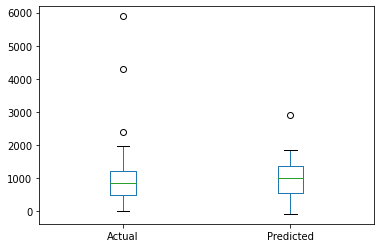

In [654]:
#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(y_test, model_lr.predict(x_test)))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(y, model_lr.predict(x)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_lr.head(20).plot(kind = 'box')

In [655]:
final_high_df["y_lr"]=model_lr.predict(x)

# Logistic Regression

In [656]:
model_log = LogisticRegression()
model_log.fit(x_train,y_train)
y_pred = model_log.predict(x_test)
result_log = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
result_log.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Actual,Predicted
27,1013.0,1083.0
498,879.0,1056.0
332,0.0,0.0
243,5891.0,5739.0
595,2378.0,1069.0


Mean Absolute Error Test   : 339.6806282722513
Mean Absolute Error All    : 134.8820754716981


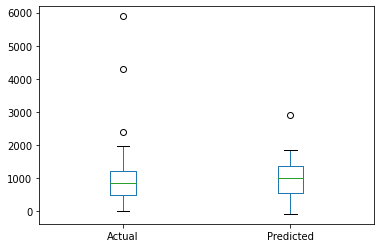

In [657]:
#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(y, model_log.predict(x)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_lr.head(20).plot(kind = 'box')

In [658]:
final_high_df["y_log"]=model_log.predict(x)

# SVR

In [659]:
model_svr = SVR(C=1.0, max_iter=200)
model_svr.fit(x_train, y_train)
y_pred = model_svr.predict(x_test)
result_svr = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
result_svr.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


,Actual,Predicted
27,1013.0,774.076793
498,879.0,763.383733
332,0.0,739.408399
243,5891.0,753.848150
595,2378.0,757.398244


Mean Absolute Error Test   : 684.410869344173
Mean Absolute Error All    : 676.6864017857092


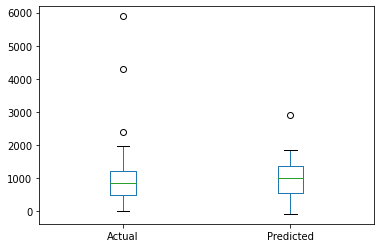

In [660]:
#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(y, model_svr.predict(x)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_lr.head(20).plot(kind = 'box')

In [661]:
final_high_df["y_svr"]=model_svr.predict(x)

LGBM

In [662]:
lgb_model = LGBMRegressor(subsample=0.9)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(200, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=42, 
                                 verbose=10, return_train_score=True)
lgb_random = lgb_random.fit(x_train, y_train)
best_params = lgb_random.best_params_
model_lgbm = LGBMRegressor(**best_params, subsample=0.9, random_state=42, n_jobs=-1)
model_lgbm.fit(x_train, y_train)
y_pred = model_lgbm.predict(x_test)
result_lgbm = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
result_lgbm.head(5)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122, score=(train=1.000, test=0.241), total=   1.1s
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122, score=(train=1.000, test=0.020), total=   0.7s
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122, score=(train=1.000, test=0.263), total=   0.6s
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123, score=(train=1.000, test=0.408), total=   0.6s
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.0s remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123, score=(train=1.000, test=0.509), total=   1.4s
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=1323, num_leaves=123, score=(train=0.999, test=0.505), total=   0.9s
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.3s remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149, score=(train=0.868, test=0.557), total=   0.2s
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.5s remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149, score=(train=0.896, test=0.542), total=   0.3s
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.8s remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1005, num_leaves=149, score=(train=0.897, test=0.569), total=   0.3s
[CV] colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.1s remaining:    0.0s


[CV]  colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=0.977, test=0.278), total=   0.2s
[CV] colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 
[CV]  colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=0.976, test=0.430), total=   0.3s
[CV] colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 
[CV]  colsample_bytree=0.18182496720710062, learning_rate=0.18340450985343382, max_depth=13, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=0.971, test=0.288), total=   0.2s
[CV] colsample_bytree=0.2912291401980419,

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   28.5s finished


,Actual,Predicted
27,1013.0,1322.668852
498,879.0,808.928666
332,0.0,38.615970
243,5891.0,3429.285461
595,2378.0,872.894793


Mean Absolute Error Test   : 373.68164890335646
Mean Absolute Error All    : 286.3978612020374


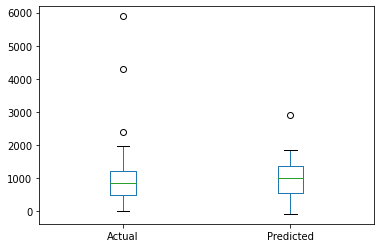

In [663]:
#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(y, model_lgbm.predict(x)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_lr.head(20).plot(kind = 'box')

In [664]:
final_high_df["y_lgbm"]=model_lgbm.predict(x)

# Stacking

In [665]:
final_high_df.head(5)

,PM2.5_average,PM2.5_minimum,NO2_average,NO2_minimum,SO2_average,SO2_minimum,CO_average,CO_minimum,OZONE_average,OZONE_minimum,Total_Day_Cases,y_lr,y_log,y_svr,y_lgbm
0,24.000000,3.0,12.000000,1.0,10.333333,1.0,30.666667,5.0,52.666667,17.0,1189.0,1102.096412,563.0,751.609604,1190.257590
1,25.500000,5.0,15.000000,2.0,13.000000,1.0,32.000000,6.0,44.500000,18.0,1180.0,1139.505964,648.0,750.935858,1174.385624
2,30.000000,4.0,23.500000,8.0,7.500000,1.0,36.500000,2.0,62.000000,5.0,1235.0,1186.856589,1235.0,755.657679,986.459208
3,22.000000,8.0,12.000000,8.0,25.000000,3.0,38.500000,28.0,36.500000,3.0,1089.0,1119.694212,1089.0,752.737951,994.873376
4,16.666667,1.0,12.333333,1.0,7.333333,1.0,35.000000,10.0,65.000000,2.0,1299.0,1035.605029,1299.0,752.659711,1095.599508


Train Test split

In [666]:
X  = final_high_df.drop(columns = ['Total_Day_Cases'])
Y  = final_high_df['Total_Day_Cases']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

Linear Regression

Mean Absolute Error Test   : 321.7643184457619
Mean Absolute Error All    : 170.88557287891325


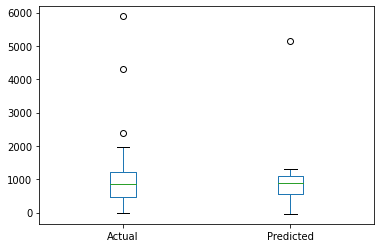

In [667]:
model_s_lr = LinearRegression()
model_s_lr.fit(X_train,Y_train)
Y_pred = model_s_lr.predict(X_test)
result_s_lr = pd.DataFrame({'Actual':Y_test,'Predicted':Y_pred})

#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(Y, model_s_lr.predict(X)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_s_lr.head(20).plot(kind = 'box')

Logistic Regression

Mean Absolute Error Test   : 338.21989528795814
Mean Absolute Error All    : 133.36635220125785


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


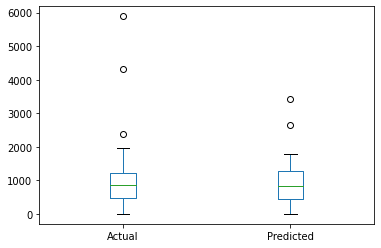

In [668]:
model_s_log = LogisticRegression()
model_s_log.fit(X_train,Y_train)
Y_pred = model_s_log.predict(X_test)
result_s_log = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})

#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(Y, model_s_log.predict(X)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_s_log.head(20).plot(kind = 'box')

In [669]:
X  = final_high_df.drop(columns = average_min_cols)
Y  = final_high_df['Total_Day_Cases']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

Mean Absolute Error Test   : 323.3741549485614
Mean Absolute Error All    : 170.7590769747376


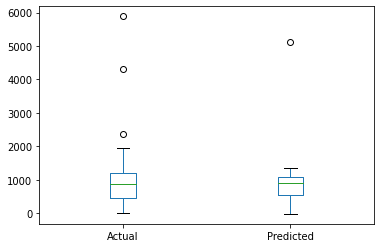

In [670]:
model_s_lr = LinearRegression()
model_s_lr.fit(X_train,Y_train)
Y_pred = model_s_lr.predict(X_test)
result_s_lr = pd.DataFrame({'Actual':Y_test,'Predicted':Y_pred})

#print('Mean Absolute Error Train  :', metrics.mean_absolute_error(y_train, model_lr.predict(x_train)))
print('Mean Absolute Error Test   :', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Absolute Error All    :', metrics.mean_absolute_error(Y, model_s_lr.predict(X)))
#final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape
result_s_lr.head(20).plot(kind = 'box')

In [671]:
final_high_df["Total_Cases_Predicted"]=model_s_lr.predict(X)
final_high_df["PM2.5_AQI_Category"]=final_df["PM2.5_AQI_Category"]
final_high_df[(final_high_df["Total_Day_Cases"]-final_high_df["Total_Cases_Predicted"])>500].shape

(24, 17)

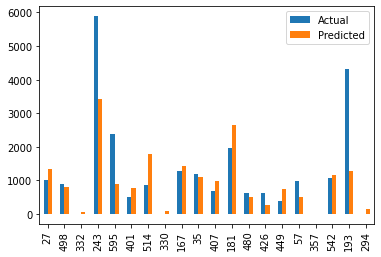

In [672]:
result_s_log.head(20).plot(kind = 'bar')

In [673]:
final_high_df

,PM2.5_average,PM2.5_minimum,NO2_average,NO2_minimum,SO2_average,SO2_minimum,CO_average,CO_minimum,OZONE_average,OZONE_minimum,Total_Day_Cases,y_lr,y_log,y_svr,y_lgbm,Total_Cases_Predicted,PM2.5_AQI_Category
0,24.000000,3.0,12.000000,1.0,10.333333,1.0,30.666667,5.0,52.666667,17.0,1189.0,1102.096412,563.0,751.609604,1190.257590,765.788094,Good
1,25.500000,5.0,15.000000,2.0,13.000000,1.0,32.000000,6.0,44.500000,18.0,1180.0,1139.505964,648.0,750.935858,1174.385624,815.633131,Good
2,30.000000,4.0,23.500000,8.0,7.500000,1.0,36.500000,2.0,62.000000,5.0,1235.0,1186.856589,1235.0,755.657679,986.459208,1137.803803,Good
3,22.000000,8.0,12.000000,8.0,25.000000,3.0,38.500000,28.0,36.500000,3.0,1089.0,1119.694212,1089.0,752.737951,994.873376,1049.429244,Good
4,16.666667,1.0,12.333333,1.0,7.333333,1.0,35.000000,10.0,65.000000,2.0,1299.0,1035.605029,1299.0,752.659711,1095.599508,1245.843640,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,154.285714,43.0,51.600000,1.0,15.444444,2.0,60.400000,21.0,21.600000,1.0,577.0,1327.453315,409.0,753.037498,689.612583,428.377292,Very Poor
656,137.625000,40.0,51.700000,1.0,14.555556,2.0,50.400000,16.0,25.500000,1.0,409.0,1129.282501,409.0,755.221746,749.020670,469.988067,Very Poor
657,102.444444,37.0,44.444444,1.0,13.375000,2.0,46.555556,13.0,28.333333,3.0,541.0,935.229365,541.0,761.409589,785.725520,589.343485,Poor
658,120.750000,53.0,46.000000,1.0,13.125000,2.0,55.400000,14.0,19.400000,1.0,871.0,916.887368,576.0,754.398983,952.119868,692.112427,Poor


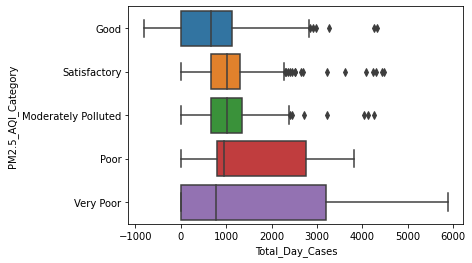

In [674]:
sns.boxplot(data=final_high_df,x="Total_Day_Cases",y="PM2.5_AQI_Category",orient="h")

In [675]:
for category in ["Good","Satisfactory","Moderately Polluted","Very Poor","Poor"]:
    print(category)
    data_df=final_high_df[final_high_df["PM2.5_AQI_Category"]==category]
    print('Mean Absolute Error All    :', metrics.mean_absolute_error(data_df["Total_Day_Cases"],data_df["Total_Cases_Predicted"]))

Good
Mean Absolute Error All    : 153.0166622072952
Satisfactory
Mean Absolute Error All    : 186.49865814758135
Moderately Polluted
Mean Absolute Error All    : 188.6826653552823
Very Poor
Mean Absolute Error All    : 195.5047399636779
Poor
Mean Absolute Error All    : 111.27818746176396


In [501]:
for category in pm2_5_aqi_categories:
    print(category)
    data_df=final_high_df[final_high_df["PM2.5_AQI_Category"]==category]
    print('Mean Absolute Error All    :', metrics.mean_absolute_error(data_df["Total_Day_Cases"],data_df["Total_Cases_Predicted"]))

Good
Mean Absolute Error All    : 175.40923219701202
Satisfactory
Mean Absolute Error All    : 194.74205987646684
Moderately Polluted
Mean Absolute Error All    : 180.4107443131397
Very Poor
Mean Absolute Error All    : 240.74421391242953
Poor
Mean Absolute Error All    : 169.33065669682847
Severe
Mean Absolute Error All    : 799.9381966707818


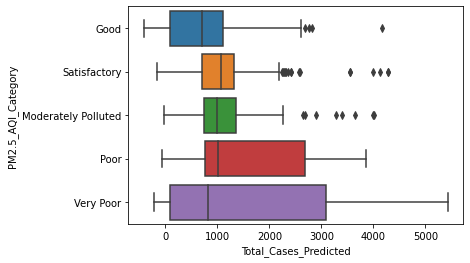

In [676]:
sns.boxplot(data=final_high_df,x="Total_Cases_Predicted",y="PM2.5_AQI_Category",orient="h")

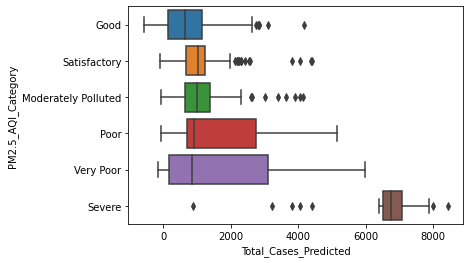

In [492]:
sns.boxplot(data=final_high_df,x="Total_Cases_Predicted",y="PM2.5_AQI_Category",orient="h")

In [677]:
for category in ["Good","Satisfactory","Moderately Polluted","Very Poor","Poor"]:
    print(category)
    data_df=final_high_df[final_high_df["PM2.5_AQI_Category"]==category]
    print('Mean Absolute Error All    :', metrics.mean_absolute_error(data_df["Total_Day_Cases"],data_df["y_log"]))

Good
Mean Absolute Error All    : 131.4262295081967
Satisfactory
Mean Absolute Error All    : 159.46445497630333
Moderately Polluted
Mean Absolute Error All    : 134.1685393258427
Very Poor
Mean Absolute Error All    : 113.72413793103448
Poor
Mean Absolute Error All    : 45.088235294117645


In [645]:
for category in pm2_5_aqi_categories:
    print(category)
    data_df=final_high_df[final_high_df["PM2.5_AQI_Category"]==category]
    print('Mean Absolute Error All    :', metrics.mean_absolute_error(data_df["Total_Day_Cases"],data_df["y_log"]))

Good
Mean Absolute Error All    : 96.49152542372882
Satisfactory
Mean Absolute Error All    : 144.86885245901638
Moderately Polluted
Mean Absolute Error All    : 296.65671641791045
Very Poor
Mean Absolute Error All    : 124.33333333333333
Poor
Mean Absolute Error All    : 143.75
Severe


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

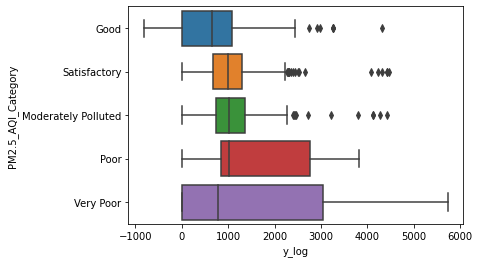

In [678]:
sns.boxplot(data=final_high_df,x="y_log",y="PM2.5_AQI_Category",orient="h")

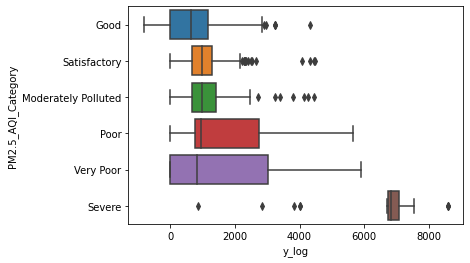

In [494]:
sns.boxplot(data=final_high_df,x="y_log",y="PM2.5_AQI_Category",orient="h")

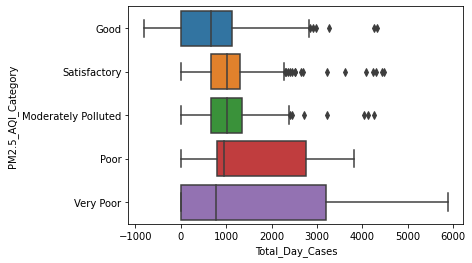

In [540]:
sns.boxplot(data=final_high_df,x="Total_Day_Cases",y="PM2.5_AQI_Category",orient="h")